## Importing necessary Libraries and packages

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import cv2 as cv
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
from PIL import Image

## Creating The Dataset For the Model

In [ ]:
X=[]
Z=[]
IMG_SIZE=224
MOHIT_DIR = '/content/drive/MyDrive/Colab Notebooks/Faces/Mohit_Kulkarni'
Kapil_DIR = '/content/drive/MyDrive/Colab Notebooks/Faces/Kapil_Kulkarni'
Harshal_DIR = '/content/drive/MyDrive/Colab Notebooks/Faces/Harshal_Korade'


In [ ]:
def assign_label(img,person_name):
    return person_name

In [ ]:
def make_train_data(person_name,DIR):
  for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,person_name)
        path = os.path.join(DIR,img)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Mohit',MOHIT_DIR)
print(len(X))

100%|██████████| 100/100 [00:01<00:00, 55.54it/s]

100


In [ ]:
make_train_data('Kapil Kulkarni',Kapil_DIR)
print(len(X))

100%|██████████| 100/100 [00:03<00:00, 29.97it/s]

200


In [ ]:

make_train_data('Harshal Korade',Harshal_DIR)
print(len(X))

100%|██████████| 100/100 [00:01<00:00, 54.43it/s]

300


In [ ]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=keras.utils.to_categorical(Y,3)
X=np.array(X)
X=X/255

## Splitting the data into training and test set

In [ ]:
# Splitting into Training and Validation Sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42,stratify=Y)

In [ ]:
import random as rn
np.random.seed(42)
rn.seed(42)

## Creating The CNN Model Architecture

In [ ]:
model = keras.applications.vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def layer_adder(bottom_model, num_classes):
    
    top_model = bottom_model.output
    
    #top_model = keras.layers.InputLayer()(top_model)
    
    top_model = keras.layers.MaxPooling2D(pool_size=(2,2))(top_model)

    top_model = keras.layers.Flatten()(top_model)

    top_model = keras.layers.Dense(1024, activation='relu')(top_model)
    top_model = keras.layers.Dense(512, activation='relu')(top_model)
    top_model = keras.layers.Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
num_classes = 3
FC_Head = layer_adder(model,num_classes)

model = keras.models.Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs=2

red_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## Data Augmentation

In [ ]:
#Data Augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Compiling the Keras Model & Summary

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Training the Model

In [ ]:
# Train the Model
History = model.fit(x_train,y_train,epochs=epochs,validation_data = (x_test,y_test))

Epoch 1/2
8/8 [==============================] - 17s 483ms/step - loss: 1.1287 - accuracy: 0.6489 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 2/2
8/8 [==============================] - 1s 180ms/step - loss: 0.0181 - accuracy: 0.9911 - val_loss: 8.4356e-04 - val_accuracy: 1.0000


## Post Processing on Model

In [ ]:
History.history

{'loss': [1.1287431716918945, 0.01808847300708294],
 'accuracy': [0.648888885974884, 0.9911110997200012],
 'val_loss': [0.0058275796473026276, 0.0008435604977421463],
 'val_accuracy': [1.0, 1.0]}

In [ ]:
test_evaluation = model.evaluate(x_test,y_test)
test_evaluation

3/3 [==============================] - 0s 115ms/step - loss: 8.4356e-04 - accuracy: 1.0000


[0.0008435604977421463, 1.0]

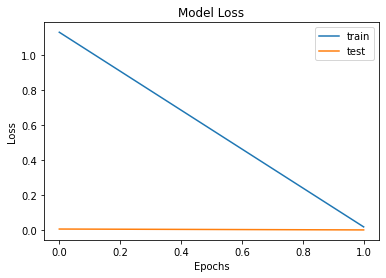

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

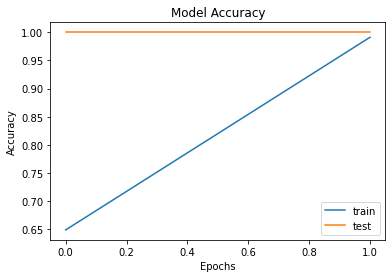

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

ValueError: ignored

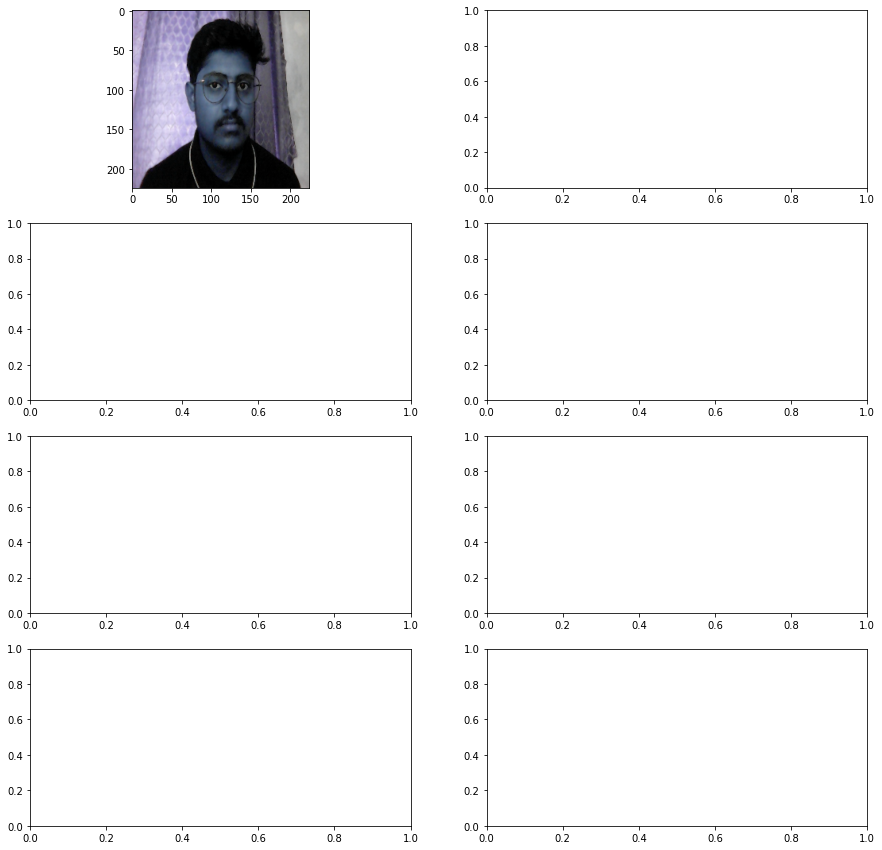

In [ ]:
import warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

IndexError: ignored

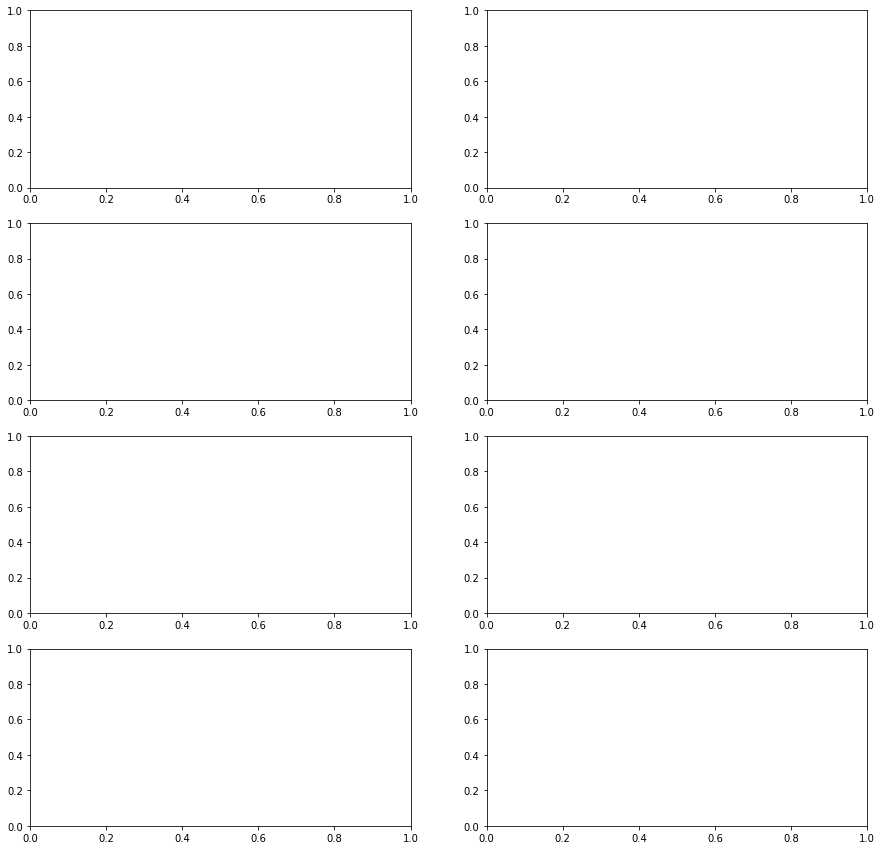

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1


In [ ]:
model.save('F:/PBL Project/Model_1.h5')

## Evaluating The Model

In [ ]:
model.evaluate(x_test, y_test, verbose=0)

[0.0008435604977421463, 1.0]

## Testing The Image

In [ ]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/akshaykumar21631196177.webp')
image.resize((224,224,3))
#model.predict(np.expand_dims(np.array(image), axis=0))
y_pred = np.argmax(model.predict(np.expand_dims(np.array(image), axis=0)), axis=-1)


In [ ]:
#np.array()[y_pred]
print(y_pred)

[0]
